# Classification. Linear models and KNN

In [240]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [241]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [242]:
#PATH = "./data/"

In [243]:
data = pd.read_csv('train.csv').set_index('PassengerId')
train = pd.read_csv('train.csv').set_index('PassengerId')
test = pd.read_csv('test.csv').set_index('PassengerId')

In [244]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [245]:
data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [246]:
data.loc[data["Survived"] == 1]["Sex"].value_counts()

female    233
male      109
Name: Sex, dtype: int64

            SexInt  Survived
SexInt    1.000000  0.543351
Survived  0.543351  1.000000


,Sex,Survived
0,female,0.742038
1,male,0.188908


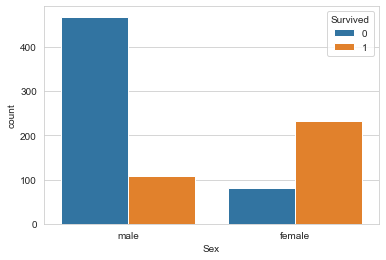

In [247]:
#p = sns.FacetGrid(data, col='Survived')
#p.map(plt.hist, 'Sex')
sns.set_style('whitegrid')
sns.countplot(x = 'Sex',hue='Survived',data=data)
data['SexInt']=(data['Sex']=='female').astype(int)
print(data[['SexInt','Survived']].corr())
data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

<i> As it can be seen from the results of the analysis, there is about a 75 % probability that a female would survive the crash, for males the probability drops to about 19 %. Also from the correlation value we can see that there is a strong correlation between a person's sex and survival possibility. Maybe there was a policy to give the females the first turn to disembark over the males.</i>

/**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

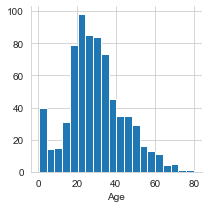

In [248]:
p = sns.FacetGrid(data)
p.map(plt.hist, 'Age', bins=20)

In [249]:
print("Average")
data[['Age', 'Survived']].groupby(['Survived'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Average


,Survived,Age
1,1,28.343690
0,0,30.626179


In [250]:
print("Median")
data[['Age', 'Survived']].groupby(['Survived'], as_index=False).median().sort_values(by='Survived', ascending=False)

Median


,Survived,Age
1,1,28.0
0,0,28.0


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


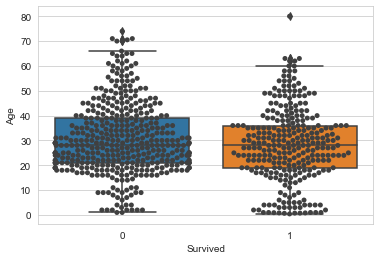

In [251]:
ax=sns.boxplot(x="Survived", y="Age", data=data)
ax = sns.swarmplot(x="Survived", y="Age", data=data, color=".25")

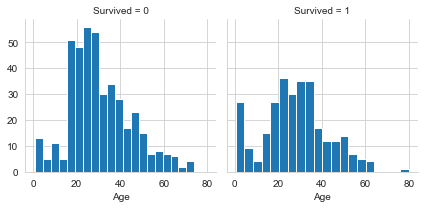

In [252]:
p = sns.FacetGrid(data, col='Survived')
p.map(plt.hist, 'Age', bins=20)

<i>It can be seen from the tables that the average age of the survived and the dead were 28 and 31 correspondingly. For both classes the median value is 28. From the plots we can see that infants had higher survival rate. The oldest passengers survived. A lot of 15-25 year olds did not survive. Most passengers are in 20-40 age range.
Maybe there was a policy to give children and eldery the first turn to disembark over everybody else.</i>

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [253]:
print("Embarked")
print(data["Embarked"].describe())
print("Pclass")
print(data["Pclass"].describe()) 


Embarked
count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object
Pclass
count    891.000000
mean       2.308642
std        0.836071
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: Pclass, dtype: float64


Died
1     80
2     97
3    372
Name: Pclass, dtype: int64
Survived
1    136
2     87
3    119
Name: Pclass, dtype: int64


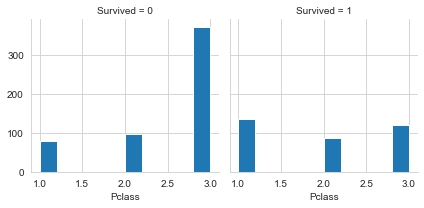

In [254]:
print("Died")
print(data.loc[data["Survived"] == 0]["Pclass"].value_counts().sort_index())
print("Survived")
print(data.loc[data["Survived"] == 1]["Pclass"].value_counts().sort_index())
p = sns.FacetGrid(data, col='Survived')
p.map(plt.hist, 'Pclass')



C:\Users\Alex\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Alex\anaconda3\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


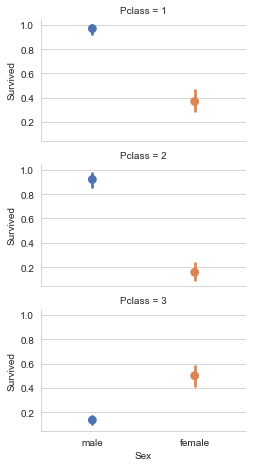

In [255]:
grid = sns.FacetGrid(data, row='Pclass', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Sex','Survived',  palette='deep')
grid.add_legend()

<AxesSubplot:xlabel='Pclass', ylabel='count'>

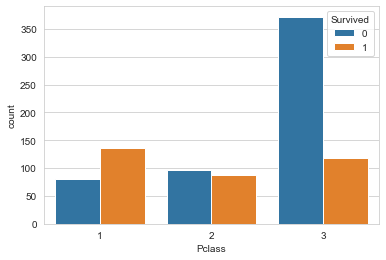

In [256]:
sns.countplot(x = 'Pclass',hue='Survived',data=data)

Died
C     75
Q     47
S    427
Name: Embarked, dtype: int64
Survived
C     93
Q     30
S    217
Name: Embarked, dtype: int64


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Alex\anaconda3\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


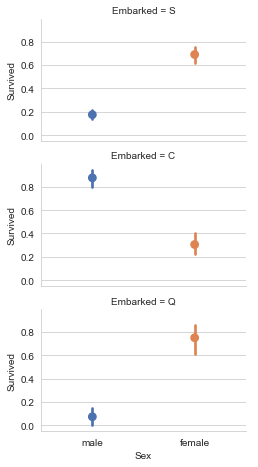

In [257]:
print("Died")
print(data.loc[data["Survived"] == 0]["Embarked"].value_counts().sort_index())
print("Survived")
print(data.loc[data["Survived"] == 1]["Embarked"].value_counts().sort_index())
#sns.FacetGrid(data, col='Embarked', hue='Survived')

grid = sns.FacetGrid(data, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot,  'Sex','Survived', palette='deep')#'Pclass', 
grid.add_legend()
 

<AxesSubplot:xlabel='Embarked', ylabel='count'>

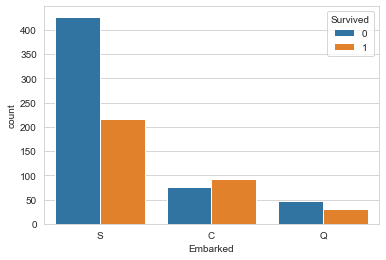

In [258]:
sns.countplot(x = 'Embarked',hue='Survived',data=data)

<i>From the analysis above we can conclude that the 3d class is the biggest, and many people with 3d class tickets died. The probability that people from second class could die is almost the same to the probability of survival.As for the first class, people in this categpry were more likely to survive than to die.
For the males on the first class, the survival probability is higher than for the females. For the third class the case the situation is the opposite.


Most people embarked at S with almost 2/3 dieing. For people from C the probability of their survival was higher, while for the people from Q the probability of death was higher.
The women from Q and S had higher survival probability than men, while for the people from C the situation turned around. 
</i>

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [259]:
(train.isnull().sum()/train.shape[0])*100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

In [260]:
(test.isnull().sum()/test.shape[0])*100

Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         20.574163
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.239234
Cabin       78.229665
Embarked     0.000000
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

<i>
It can be seen that there are values missing from the columns Embarked, Age, Fare and Cabin in train and test datasets.    
    
There are many different ways to handle missing values. One of them is to substitute the missing values with the mean or median for the corresponding values. The advantages are that the statistics for the column doesn't change, and the all the values are on equal computing ground. On the other hand we make a big assumption for the behaviour of the environment and the research object. The missing values could contain additional information that is relevant to the data research task.
Another type of filling the missing values in induction - finding a pattern and filling the empty places according to the found information. The advantages and disadventages are similar, but here we make an additional assumption that the values for the empty spaces behave in the same way as the rest of the existing data. 
If there is too much data missing then it is possible to drop the column.
</i>

In [261]:
train["Embarked"].fillna("S", inplace=True) # with the most frequent
train["Age"].fillna(train["Age"].dropna().median(), inplace = True) 

test["Age"].fillna(test["Age"].dropna().median(), inplace = True) 
test["Fare"].fillna(test["Fare"].dropna().median(), inplace=True)

In [262]:
X_train = train.drop(["Survived","Ticket","Cabin"], axis=1)
Y_train = train["Survived"]
X_test  = test.drop(["Ticket","Cabin"], axis=1)
print(X_train.shape, Y_train.shape, X_test.shape)

print((X_train.isnull().sum()/X_train.shape[0])*100)
print((X_test.isnull().sum()/X_test.shape[0])*100)

(891, 8) (891,) (418, 8)
Pclass      0.0
Name        0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Fare        0.0
Embarked    0.0
dtype: float64
Pclass      0.0
Name        0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Fare        0.0
Embarked    0.0
dtype: float64


**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [263]:
X_train.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.361582,0.523008,0.381594,32.204208
std,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,35.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [264]:
combine = [X_train, X_test]

In [265]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

X_train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Don           1
Jonkheer      1
Mme           1
Ms            1
Sir           1
Capt          1
Lady          1
Countess      1
Name: Title, dtype: int64

In [266]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona','Master'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
X_train['Title'].value_counts()
X_test['Title'].value_counts()

Mr      240
Miss     79
Mrs      72
Rare     27
Name: Title, dtype: int64

In [267]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3,  "Rare": 4}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)


In [268]:
X_train = X_train.drop(['Name'], axis=1)
X_test = X_test.drop(['Name'], axis=1)
combine = [X_train, X_test]

In [269]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)


In [270]:
X_train['AgeBand'] = pd.cut(X_train['Age'], 5)
X_train['AgeBand'].value_counts()

(16.336, 32.252]    523
(32.252, 48.168]    188
(0.34, 16.336]      100
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: AgeBand, dtype: int64

In [271]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
X_train = X_train.drop(['AgeBand'], axis=1)
combine = [X_train, X_test]

In [272]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [273]:
X_train['FareBand'] = pd.qcut(X_train['Fare'], 4)
X_train['FareBand'].value_counts()
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    
X_train = X_train.drop(['FareBand'], axis=1)
combine = [X_train, X_test]

In [274]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,0,1.0,1,0,0,0,1
2,1,1,2.0,1,0,3,1,3
3,3,1,1.0,0,0,1,0,2
4,1,1,2.0,1,0,3,0,3
5,3,0,2.0,0,0,1,0,1


In [275]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
892,3,0,2.0,0,0,0,2,1
893,3,1,2.0,1,0,0,0,3
894,2,0,3.0,0,0,1,2,1
895,3,0,1.0,0,0,1,0,1
896,3,1,1.0,1,1,1,0,3


In [276]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [281]:
pd.DataFrame(data=X_train)
pd.DataFrame(data=X_test)

,0,1,2,3,4,5,6,7
0,0.827377,-0.737695,-0.013479,-0.474545,-0.473674,-1.346777,2.579199,-0.734077
1,0.827377,1.355574,-0.013479,0.432793,-0.473674,-1.346777,-0.568837,1.355579
2,-0.369365,-0.737695,0.117779,-0.474545,-0.473674,-0.451938,2.579199,-0.734077
3,0.827377,-0.737695,-0.144738,-0.474545,-0.473674,-0.451938,-0.568837,-0.734077
4,0.827377,1.355574,-0.144738,0.432793,0.767630,-0.451938,-0.568837,1.355579
...,...,...,...,...,...,...,...,...
413,0.827377,-0.737695,-0.144738,-0.474545,-0.473674,-0.451938,-0.568837,-0.734077
414,-1.566107,1.355574,-0.013479,-0.474545,-0.473674,1.337738,1.005181,2.400407
415,0.827377,-0.737695,-0.013479,-0.474545,-0.473674,-1.346777,-0.568837,-0.734077
416,0.827377,-0.737695,-0.144738,-0.474545,-0.473674,-0.451938,-0.568837,-0.734077


In [289]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")


In [296]:
#KNN
#accuracy as a metric, cross-validation
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, Y_train)
Y_pred_knn = knn.predict(X_train)
print(metrics.accuracy_score(y_pred=Y_pred_knn, y_true=Y_train % 2))
print('Result for cross-validation: {:f}'.format(cross_val_score(knn, X_train, 
                                                           Y_train, scoring='accuracy', cv=5).mean()))


0.856341189674523
Result for cross-validation: 0.819315


In [297]:
#Logistic Regression
#accuracy as a metric, cross-validation

lr = LogisticRegression(solver='liblinear', penalty='l1')
lr.fit(X_train, Y_train)
Y_pred_lr = lr.predict(X_train)
print(metrics.accuracy_score(y_pred=Y_pred_lr, y_true=Y_train % 2))
print('Result for cross-validation: {:f}'.format(cross_val_score(lr, X_train, 
                                                           Y_train, scoring='accuracy', cv=5).mean()))


0.8080808080808081
Result for cross-validation: 0.799102


In [298]:
selector = SequentialFeatureSelector(RandomForestClassifier(random_state=42), scoring='accuracy', n_jobs=-1).fit(X_train, Y_train)
X_pruned_tr = selector.transform(X_train)
X_pruned_t = selector.transform(X_test)
print("After selection")
print("KNN")
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_pruned_tr, Y_train)
Y_pred_knn = knn.predict(X_pruned_tr)
print(metrics.accuracy_score(y_pred=Y_pred_knn, y_true=Y_train % 2))
print('Result for cross-validation: {:f}'.format(cross_val_score(knn, X_pruned_tr, 
                                                           Y_train, scoring='accuracy', cv=5).mean()))

print("LR")
lr = LogisticRegression(solver='liblinear', penalty='l1')
lr.fit(X_pruned_tr, Y_train)
Y_pred_lr = lr.predict(X_pruned_tr)
print(metrics.accuracy_score(y_pred=Y_pred_lr, y_true=Y_train % 2))
print('Result for cross-validation: {:f}'.format(cross_val_score(lr, X_pruned_tr, 
                                                           Y_train, scoring='accuracy', cv=5).mean()))


After selection
KNN
0.7968574635241302
Result for cross-validation: 0.782349
LR
0.8013468013468014
Result for cross-validation: 0.803572


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [347]:
model_params = {
    "Logistic Regressor":{
        "model": LogisticRegression(),
        "params":{"C":[0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty":["l1","l2"]}
    },
    "K Neighbors Classifier":{
        "model": KNeighborsClassifier(),
        "params":{"n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
                                  16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}
    },
    "Random Forest Classifier":{
        "model": RandomForestClassifier(),
        "params": { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
      }
    }
}

In [302]:
'''
for model_name, p in model_params.items():
    model = p["model"]
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_train)
    
    acc = metrics.accuracy_score(Y_train, y_pred)
    print(model_name, acc, "\n")
    
    scores = cross_val_score(model, X_train, Y_train, cv=5, scoring="accuracy")
    
    print(f"""Scores: {scores},Mean: {scores.mean()},Standard Deviation: {scores.std()} """  )
'''    

'\nfor model_name, p in model_params.items():\n    model = p["model"]\n    model.fit(X_train, Y_train)\n    y_pred = model.predict(X_train)\n    \n    acc = metrics.accuracy_score(Y_train, y_pred)\n    print(model_name, acc, "\n")\n    \n    scores = cross_val_score(model, X_train, Y_train, cv=5, scoring="accuracy")\n    \n    print(f"""Scores: {scores},Mean: {scores.mean()},Standard Deviation: {scores.std()} """  )\n'

In [352]:
import warnings
warnings.filterwarnings("ignore")

scores = {}
for model_name, mp in  model_params.items():
    grid_search = GridSearchCV(mp["model"], mp["params"], cv=5, return_train_score=True,scoring="accuracy")
    grid_search.fit(X_train, Y_train)
    scores[model_name] = {"best_param":grid_search.best_params_,
                          "best_score":grid_search.best_score_}
    print(f"{model_name} - {grid_search.best_score_}")

print("With Selection")
    
for model_name, mp in  model_params.items():
    grid_search = GridSearchCV(mp["model"], mp["params"], cv=5, return_train_score=True,scoring="accuracy")
    grid_search.fit(X_pruned_tr, Y_train)
    scores[model_name+"+Selection"] = {"best_param":grid_search.best_params_,
                          "best_score":grid_search.best_score_}
    print(f"{model_name} - {grid_search.best_score_}")

    

Logistic Regressor - 0.8058313979034587
K Neighbors Classifier - 0.8260498399347185
Random Forest Classifier - 0.8271483271608814
With Selection
Logistic Regressor - 0.7979913376435881
K Neighbors Classifier - 0.8036155922415418
Random Forest Classifier - 0.8226476680685456


In [355]:
pd.set_option("display.max_colwidth",None)
pd.DataFrame.from_dict(scores, orient="index").sort_values(by="best_score", ascending=False)

,best_param,best_score
Random Forest Classifier,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}",0.827148
K Neighbors Classifier,{'n_neighbors': 6},0.826050
Random Forest Classifier+Selection,"{'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 200}",0.822648
Logistic Regressor,"{'C': 0.01, 'penalty': 'l2'}",0.805831
K Neighbors Classifier+Selection,{'n_neighbors': 9},0.803616
Logistic Regressor+Selection,"{'C': 0.01, 'penalty': 'l2'}",0.797991


In [356]:
# Dimension Reduction is a type of feature engineering
from sklearn.decomposition import PCA
pca = PCA(n_components=4)

X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

scores = {}
for model_name, mp in  model_params.items():
    grid_search = GridSearchCV(mp["model"], mp["params"], cv=5, return_train_score=True,scoring="accuracy")
    grid_search.fit(X_pca_train, Y_train)
    scores[model_name] = {"best_param":grid_search.best_params_,
                          "best_score":grid_search.best_score_}
    print(f"{model_name} - {grid_search.best_score_}")

pd.DataFrame.from_dict(scores, orient="index").sort_values(by="best_score", ascending=False)

Logistic Regressor - 0.8148327160881301
K Neighbors Classifier - 0.8226727763480006
Random Forest Classifier - 0.8271483271608812


,best_param,best_score
Random Forest Classifier,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}",0.827148
K Neighbors Classifier,{'n_neighbors': 28},0.822673
Logistic Regressor,"{'C': 0.01, 'penalty': 'l2'}",0.814833


In [363]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

X_pca_train_s = pca.fit_transform(X_pruned_tr)
X_pca_test_s = pca.transform(X_pruned_t)

scores = {}
for model_name, mp in  model_params.items():
    grid_search = GridSearchCV(mp["model"], mp["params"], cv=5, return_train_score=True,scoring="accuracy")
    grid_search.fit(X_pca_train_s, Y_train)
    scores[model_name] = {"best_param":grid_search.best_params_,
                          "best_score":grid_search.best_score_}
    print(f"{model_name} - {grid_search.best_score_}")

pd.DataFrame.from_dict(scores, orient="index").sort_values(by="best_score", ascending=False)

Logistic Regressor - 0.8058565061829139
K Neighbors Classifier - 0.8136902893729208
Random Forest Classifier - 0.8204067541271733


,best_param,best_score
Random Forest Classifier,"{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}",0.820407
K Neighbors Classifier,{'n_neighbors': 18},0.813690
Logistic Regressor,"{'C': 0.01, 'penalty': 'l2'}",0.805857


In [357]:
#Voting for pca
#X_pca_train
#X_pca_test

from sklearn.ensemble import VotingClassifier
clf1 = LogisticRegression(C=0.01,penalty="l2")
clf2 = KNeighborsClassifier(n_neighbors = 28)
clf3 = RandomForestClassifier(n_estimators=200,max_features='sqrt',max_depth=5,criterion= 'entropy')
    
eclf = VotingClassifier(estimators=[('lr', clf1), ('knn', clf2),('rfc',clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'KNeighbors','RandomForest', 'Ensemble']):
        scores = cross_val_score(clf, X_pca_train, Y_train, scoring='accuracy', cv=5)
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
eclf.fit(X_pca_train, Y_train)
Y_pred0 = eclf.predict(X_pca_test)

Accuracy: 0.81 (+/- 0.02) [Logistic Regression]
Accuracy: 0.82 (+/- 0.01) [KNeighbors]
Accuracy: 0.82 (+/- 0.02) [RandomForest]
Accuracy: 0.83 (+/- 0.01) [Ensemble]


Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [322]:
"""knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_pruned_tr, Y_train)
Y_pred = knn.predict(X_pruned_t)
Y_pred.shape"""

(418,)

In [360]:
#Voting 
clf1 = LogisticRegression(C=0.01,penalty="l2")
clf2 = KNeighborsClassifier(n_neighbors = 6)
clf3 = RandomForestClassifier(criterion='entropy', max_depth=5, max_features= 'auto', n_estimators=200)

eclf = VotingClassifier(estimators=[('lr', clf1), ('knn', clf2),('rfc',clf3)], voting='hard')

for clf, label in zip([clf1, clf2,clf3, eclf], ['Logistic Regression', 'KNeighbors','RandomForest', 'Ensemble']):
        scores = cross_val_score(clf, X_train, Y_train, scoring='accuracy', cv=5)
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
        
eclf.fit(X_train, Y_train)
Y_pred1 = eclf.predict(X_test)

Accuracy: 0.81 (+/- 0.01) [Logistic Regression]
Accuracy: 0.83 (+/- 0.03) [KNeighbors]
Accuracy: 0.82 (+/- 0.02) [RandomForest]
Accuracy: 0.82 (+/- 0.03) [Ensemble]


In [361]:
#Voting for selection
clf1 = LogisticRegression(C=0.01,penalty="l2")
clf2 = KNeighborsClassifier(n_neighbors = 9)
clf3 = RandomForestClassifier(criterion= 'gini', max_depth= 6, max_features='log2', n_estimators=200)

eclf = VotingClassifier(estimators=[('lr', clf1), ('knn', clf2),('rfc',clf3)], voting='hard')

for clf, label in zip([clf1, clf2,clf3, eclf], ['Logistic Regression', 'KNeighbors','RandomForest', 'Ensemble']):
        scores = cross_val_score(clf, X_pruned_tr, Y_train, scoring='accuracy', cv=5)
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
        
eclf.fit(X_pruned_tr, Y_train)
Y_pred2 = eclf.predict(X_pruned_t)

Accuracy: 0.80 (+/- 0.01) [Logistic Regression]
Accuracy: 0.80 (+/- 0.01) [KNeighbors]
Accuracy: 0.82 (+/- 0.02) [RandomForest]
Accuracy: 0.82 (+/- 0.02) [Ensemble]


In [334]:
test.index

Int64Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
            ...
            1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
           dtype='int64', name='PassengerId', length=418)

In [362]:
output = pd.DataFrame({'PassengerId': test.index, 'Survived': Y_pred0})
output.to_csv('titanic0.csv', index=False)
output = pd.DataFrame({'PassengerId': test.index, 'Survived': Y_pred1})
output.to_csv('titanic1.csv', index=False)
output = pd.DataFrame({'PassengerId': test.index, 'Survived': Y_pred2})
output.to_csv('titanic2.csv', index=False)
#score=0.7583 - KNN
#score=0.77033 - KNN with selection
##score=0.78 - ensemble with selection
#score=0.77511 - ensemble with selection with pca

#with RandomForest:
#ensamble 0 - 0.76315
#ensamble 1 - 0.76315
#ensamble 2 - 0.78229 - voting with 3 classifiers with selection !!!
##Kaggle Aleksandra Irtikeeva

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [14]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [15]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [16]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [17]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [20]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

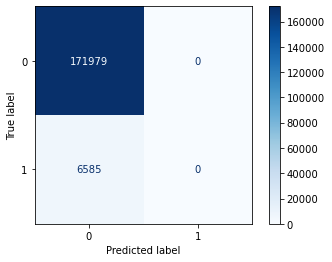

In [21]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [22]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

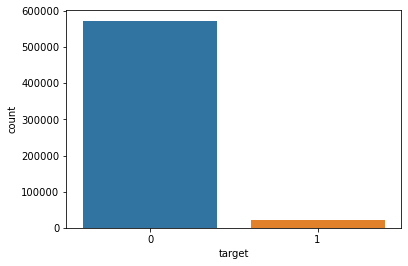

In [23]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [24]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [25]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [26]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [27]:
## your code